In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#!pip install lingpy
#import lingpy
#from lingpy import ipa2tokens
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu") #For debugging
print(f"Using device: {device}")
torch.set_default_device(device)

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## IELEX

In [ ]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("data/ielexData.csv")

df = df[['Meaning', 'Phonological Form', 'cc']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

ilexPairs = []

for _, group in df.groupby('meaning'):
    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        label = int(w1['cognate_class'] == w2['cognate_class'])
        ilexPairs.append((word1, word2, label))

import csv

# Initialize an empty set to store the languages
languages = set()

# Open and read the CSV file with UTF-8 encoding and error handling
with open('data/ielexData.csv', 'r', encoding='utf-8', errors='replace') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        languages.add(row[1])  # Add the language (second column) to the set

# Print the set of languages
print(languages)

df

## GLED

### Preprocessing

In [ ]:
df = pd.read_csv("data/gled.tsv", delimiter="\t")

df.rename(columns={'LANGUAGE_NAME': 'Language'}, inplace=True)

df['Language'] = df['Language'].str.replace('Modern Greek', 'Greek', regex=False)

df = df[df['Language'].isin(languages)]

#df = df[df.apply(lambda row: row['DOCULECT'].lower() in row['Language'].lower(), axis=1)]

#These languages seem to be aight
#df = df[df["DOCULECT"].str.contains("_2")]

#df.dropna(subset=["COGSET"], inplace=True) All of them have a cogset

df

In [ ]:
df = df[['CONCEPT', 'FORM', 'COGSET']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

pairs = []

from tqdm import tqdm
for _, group in tqdm(df.groupby('meaning')):
    #if len(pairs) > 100000:
    #    break

    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        if(word1 == word2):
            continue
        label = int(w1['cognate_class'] == w2['cognate_class'])
        #if label == 1:
        pairs.append((word1, word2, label))

In [ ]:
pairs += ilexPairs

In [ ]:
pairs

In [ ]:
pairs_df = pd.DataFrame(pairs, columns=['Word1', 'Word2', 'Label'])
pairs_df

### Levenshtein distance preprocessing

In [ ]:
all_pairs = [row[:2] for row in pairs]
all_labels = [row[2] for row in pairs]
#all_labels = [row[2:] for row in pairs]

all_characters_in_pairs = set()
for pair in all_pairs: #For all words (indiscriminately)
    for word in pair:
        all_characters_in_pairs.update(word)

from LDistanceModel import SetEmbedding
string_pair_embedder = SetEmbedding(all_characters_in_pairs, 10)

from LDistanceModel import create_batch_with_masks
ldistance_operations, ldistance_masks, ldistance_lengths = create_batch_with_masks(all_pairs, string_pair_embedder)

pairs = (ldistance_operations, ldistance_masks, torch.tensor(all_labels, device=device, dtype=torch.float))

In [30]:
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
import numpy as np
from tqdm import tqdm
import time

def cv_test_model(model_maker, has_history=False):
	cv = StratifiedKFold(n_splits = 10)
	epochs = 10000

	# Store results for each fold
	# All of these are [epoch_number, fold, (confusion_matrix, accuracy)]

	timestamps = min(30, epochs)
	
	def is_epoch_return_epoch_number(epoch):
		if epoch == 0:
			return 0

		interval = epochs / timestamps

		if epoch % interval < 1:
			return int(epoch // interval)
		return None
	
	def epoch_number_filter(epoch):
		return is_epoch_return_epoch_number(epoch) != None
	
	history = {
		"train": [
			[tuple((None, None)) for _ in range(cv.get_n_splits())]
			for _ in range(timestamps)
		],
		"test": [
			[tuple((None, None)) for _ in range(cv.get_n_splits())]
			for _ in range(timestamps)
		]
	}

	for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(pairs[0], pairs[2].cpu()), total=cv.get_n_splits(), desc="CV Progress")):
		train_idx = torch.tensor(train_idx)
		test_idx = torch.tensor(test_idx)

		# Split data
		train_data = list(zip(torch.index_select(pairs[0], 0, train_idx), torch.index_select(pairs[1], 0, train_idx), torch.index_select(pairs[2], 0, train_idx)))
		test_data = list(zip(torch.index_select(pairs[0], 0, test_idx), torch.index_select(pairs[1], 0, test_idx), torch.index_select(pairs[2], 0, test_idx)))
		
		# Create model for this fold
		model = model_maker()
		criterion = nn.BCELoss()
		optimizer = optim.Adam(model.parameters(), lr=0.001)
		
		train_loader = DataLoader(train_data, batch_size=3200, shuffle=True, 
								generator=torch.Generator(device=device.type))
		test_loader = DataLoader(test_data, batch_size=3200, 
								generator=torch.Generator(device=device.type))
		
		
		def test_against_loader(model, loader):
			"""
			Modified test_against_loader that returns predictions, probabilities, and true labels
			"""
			predictions = []
			probabilities = []  # Raw model outputs (probabilities)
			true_labels = []

			with torch.no_grad():
				for word1_batch, word2_batch, label_batch in loader:
					output_batch = model(word1_batch, word2_batch).squeeze()
					predicted_batch = (output_batch > 0.5).int()

					# Store results for the entire batch
					predictions.extend(predicted_batch.tolist())
					probabilities.extend(output_batch.tolist())  # Store raw probabilities
					true_labels.extend(label_batch.int().tolist())

			# Calculate accuracy
			accuracy = sum([pred == true for pred, true in zip(predictions, true_labels)]) / len(true_labels)

			# Additional metrics
			from sklearn.metrics import confusion_matrix
			
			# Calculate confusion matrix
			conf_matrix = confusion_matrix(true_labels, predictions)

			return conf_matrix, accuracy, probabilities, true_labels

		# Train model
		model.train()
		for epoch in range(epochs):
			total_loss = 0
			for operations, masks, labels in train_loader:	# Plural, because it's batches
				optimizer.zero_grad()
				output = model(operations, masks).squeeze()
				#print(output.get_device(), label.get_device())
				loss = criterion(output, labels)
				loss.backward()
				optimizer.step()
				total_loss += loss.item()
			#print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

			if has_history:
				epoch_number = is_epoch_return_epoch_number(epoch)
				if epoch_number == None:
					continue
				model.eval()
				history["train"][epoch_number][fold] = test_against_loader(model, train_loader)
				history["test"][epoch_number][fold] = test_against_loader(model, test_loader)

				#Early cutoff if overfitting
				if history["train"][epoch_number][fold][1] >= .99:
					history["train"] = history["train"][0:epoch_number]
					history["test"] = history["test"][0:epoch_number]
					return history, model
				
				model.train()

		if not has_history:
			history["test"][-1][fold] = test_against_loader(model, test_loader)

	return history, model


In [31]:
from LDistanceModel import LDistanceModel
#from lstm_stuff import SimplePairNN
def l_distance_model_maker():
    hidden_dim = 24

    #return SimplePairNN(vocab_size, embedding_dim, hidden_dim)
    return LDistanceModel(string_pair_embedder, hidden_dim)

history, model = cv_test_model(l_distance_model_maker, has_history=True)

CV Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
last_epoch_test_data

[(array([[5411,    0],
         [2115,    0]]),
  0.7189742226946585,
  [0.2850533127784729,
   0.25234097242355347,
   0.2684381604194641,
   0.2861213684082031,
   0.28639650344848633,
   0.2849692106246948,
   0.2867346405982971,
   0.28556200861930847,
   0.2840276062488556,
   0.29034361243247986,
   0.2898986041545868,
   0.2959442734718323,
   0.2918491065502167,
   0.28769421577453613,
   0.283163845539093,
   0.28566208481788635,
   0.2846927046775818,
   0.28431135416030884,
   0.28402596712112427,
   0.27911198139190674,
   0.26573991775512695,
   0.26971569657325745,
   0.28553512692451477,
   0.2839049994945526,
   0.2887667119503021,
   0.273870050907135,
   0.23412805795669556,
   0.26850712299346924,
   0.2835521399974823,
   0.28674396872520447,
   0.275190144777298,
   0.2556656002998352,
   0.239027202129364,
   0.26346588134765625,
   0.2822788953781128,
   0.28530481457710266,
   0.27409419417381287,
   0.26644575595855713,
   0.2704479396343231,
   0.2736567854881


Cross-Validation Results:
Overall Accuracy: 71.04%
Correct Predictions: 53461/75256


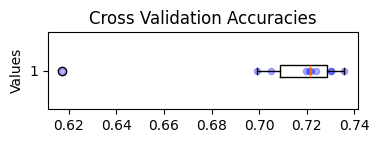

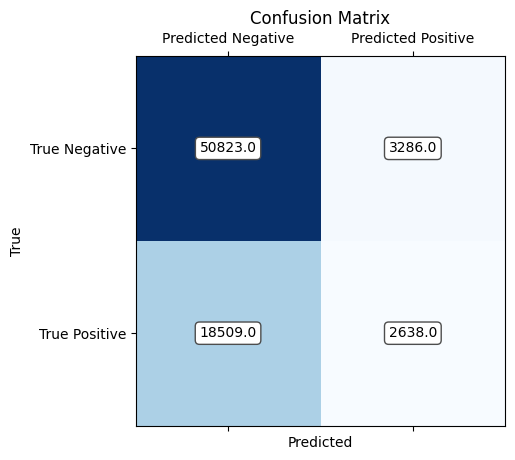

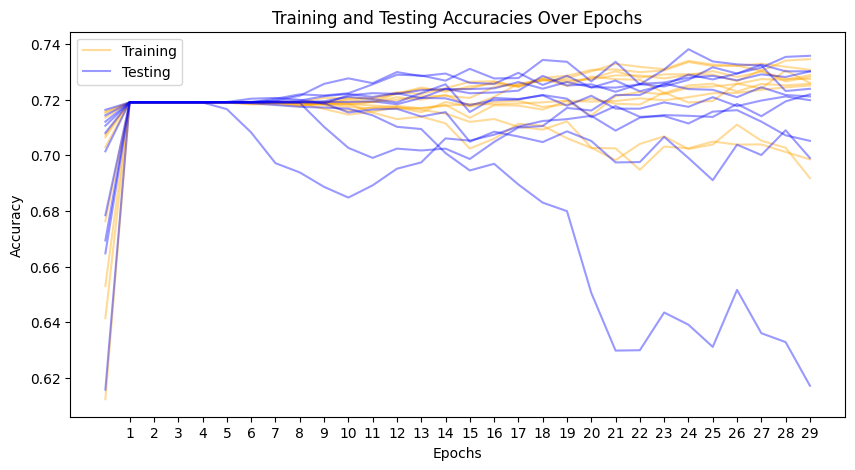

In [ ]:
# Calculate overall statistics
last_epoch_test_data = history["test"][-1] #[fold, (pred, labels, accuracies, accuracy)]

all_confusion = np.sum(np.array([fold_data[0] for fold_data in last_epoch_test_data]), axis=0)
all_accuracies = [fold_data[1] for fold_data in last_epoch_test_data]

overall_accuracy = np.mean(all_accuracies)
correct_predictions = all_confusion[1][1] + all_confusion[0][0]
total_predictions = np.sum(all_confusion)

print(f"\nCross-Validation Results:")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")

fold_accuracies = [fold_data[1] for fold_data in history["test"][-1]]

from visualization_stuff import show_box_plot, show_confusion_matrix, show_train_and_test_accuracy_over_epochs
show_box_plot(fold_accuracies)

show_confusion_matrix(all_confusion)

show_train_and_test_accuracy_over_epochs(history)

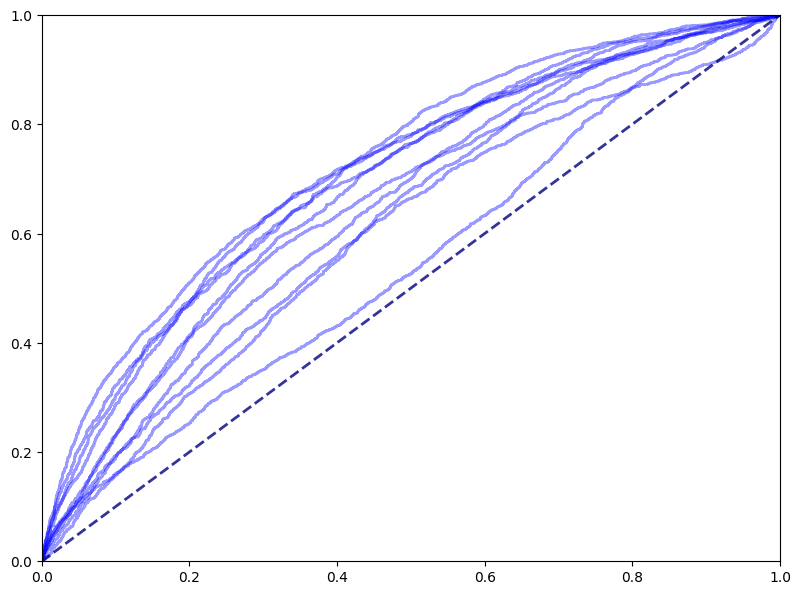

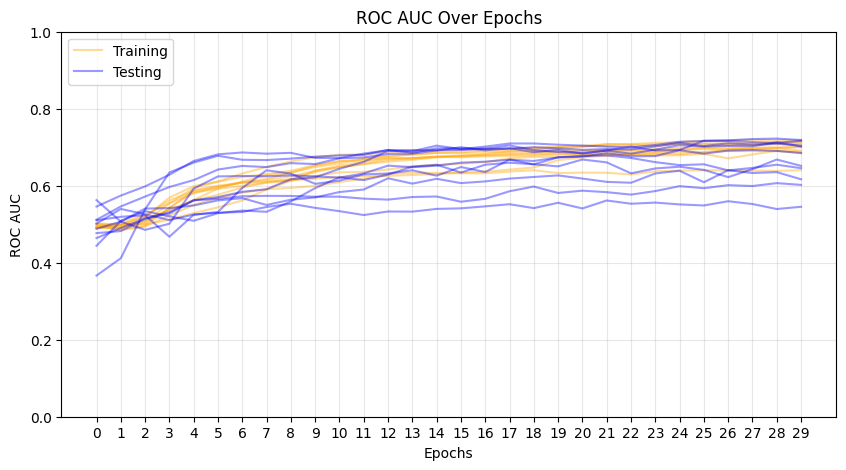

In [ ]:
from visualization_stuff import show_multiple_roc_curves, show_roc_curves_over_epochs

show_multiple_roc_curves(history)

# Show ROC AUC progression over epochs (similar to accuracy plot)
train_fold_aucs, test_fold_aucs = show_roc_curves_over_epochs(history, "ROC AUC Over Epochs")

In [ ]:
def show_classification_report(history):
    all_labels = []
    all_predictions = []
    for fold_data in history["test"][-1]:
        _, _, probabilities, true_labels = fold_data
        all_labels.extend(true_labels)
        all_predictions.extend([int(prob > .5) for prob in probabilities])
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_predictions))

show_classification_report(history)

              precision    recall  f1-score   support

           0       0.73      0.94      0.82     54109
           1       0.45      0.12      0.19     21147

    accuracy                           0.71     75256
   macro avg       0.59      0.53      0.51     75256
weighted avg       0.65      0.71      0.65     75256



https://github.com/pytorch/examples/tree/main/word_language_model